In [1]:
import numpy as np
from IPython.display import display

from notebooks.util.long_memory_utils import *
from liquidity.response_functions.features import compute_returns

from powerlaw_function.powerlaw_function import Fit

from hurst_exponent.hurst_exponent import standard_hurst, generalized_hurst
from hurst_exponent.util.utils import interpret_hurst, augmented_dickey_fuller

In [2]:
# Automatically reload changes in package dependencies
%load_ext autoreload
%autoreload 2

In [3]:
# Number of events to use
EVENTS_RANGE = 500000

# Lag/window size for Hurst and the ACF
LAG = 1000

## Load limit orders raw sample data

In [4]:
# Load raw sample data  from CSV
stocks = ['TSLA', 'AMZN', 'NFLX', 'MSFT', 'EBAY', 'APPL']

current_dir = os.path.abspath('.')
root_dir = os.path.join(current_dir, '..', '..')
data_dir = os.path.join(root_dir, 'data', 'limit_orders')
acf_data_dir = os.path.join(root_dir, 'data', 'generated', 'lo_data', 'long_memory')

stock_dfs = {}

# Loop through each stock
for stock in stocks:

    filename = f"{stock}-2016-R1-LO.csv"

    stock_file_path = os.path.join(data_dir, filename)

    # Read the CSV and store in the dictionary
    stock_dfs[stock] = pd.read_csv(stock_file_path)

# Access the dataframe using stock's ticker as key
tsla_raw_df = stock_dfs['TSLA']
amzn_raw_df = stock_dfs['AMZN']
nflx_raw_df = stock_dfs['NFLX']
msft_raw_df = stock_dfs['MSFT']
ebay_raw_df = stock_dfs['EBAY']
appl_raw_df = stock_dfs['APPL']

## 1. Returns

In [5]:
# Compute returns
tsla_returns = compute_returns(tsla_raw_df)['returns']
msft_returns = compute_returns(msft_raw_df)['returns']
amzn_returns = compute_returns(amzn_raw_df)['returns']
nflx_returns = compute_returns(nflx_raw_df)['returns']
ebay_returns = compute_returns(ebay_raw_df)['returns']
appl_returns = compute_returns(appl_raw_df)['returns']

returns = {
  'TSLA': tsla_returns,
  'MSFT': msft_returns,
  'AMZN': amzn_returns,
  'NFLX': nflx_returns,
  'EBAY': ebay_returns,
  'APPL': appl_returns
}
returns = {stock: data.head(EVENTS_RANGE) for stock, data in returns.items()}

In [6]:
# Compute ACF for TSLA using the linear method
tsla_acf = compute_acf("TSLA", tsla_returns, option="linear")
display(tsla_acf)

('TSLA',
 0       1.000000
 1      -0.029150
 2      -0.004381
 3      -0.003848
 4       0.002012
           ...   
 996    -0.000694
 997     0.000958
 998    -0.000847
 999    -0.000296
 1000    0.000399
 Length: 1001, dtype: float64)

### 1.1. Stationarity Test

To test whether our time series are stationary, we perform an augmented Dickey-Fuller test on each series, which uses the following null and alternative hypotheses:

- **H0:** The time series is non-stationary.
  - In other words, it has some time-dependent structure and does not have constant variance over time.
  - There is at least one unit root.

- **H1:** The time series is stationary.

- **Note:** If the p-value from the test is less than some significance level (e.g. $\alpha$ = .05), then we can reject the null hypothesis and conclude that the time series is stationary.

In [7]:
# ADF test
for stock, data in returns.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)

TSLA
ADF: -138.71
p-value: 0.00,
N: 499974, 
critical values: {'1%': -3.430363079347274, '5%': -2.8615457809175453, '10%': -2.566773076971239}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


MSFT
ADF: -706.76
p-value: 0.00,
N: 499999, 
critical values: {'1%': -3.430363078693302, '5%': -2.861545780628498, '10%': -2.5667730768173898}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


AMZN
ADF: -707.85
p-value: 0.00,
N: 499999, 
critical values: {'1%': -3.430363078693302, '5%': -2.861545780628498, '10%': -2.5667730768173898}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


NFLX
ADF: -166.65
p-value: 0.00,
N: 499981, 
critical values: {'1%': -3.430363079164155, '5%': -2.861545780836609, '10%': -2.56677307692816}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


EB

### 1.2. Return Autocorrelation Functions (ACFs)

There appears to be a clear difference between linear and nonlinear ACFs. If our data doesn’t contain significant non-linear patterns, both Pearson and Kendall methods could end up providing similar results.

**Key Points:**
- The **Kendall correlation** would detect non-linear relationships if they exist.
- If no non-linear relationships exist, it would just mirror the results of the Pearson correlation.
- Given this behavior, it’s best to use **Kendall** in case a non-linear relation holds for some data in our sample.


In [8]:
# Save data for lazy loading
linear_filename = f"{acf_data_dir}/lo_returns_linear_acfs.pkl"

# Linear ACF
linear_acfs = compute_acfs(filename=linear_filename, data=returns, option='linear')
print(linear_acfs.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])


In [9]:
nonlinear_filename = f"{acf_data_dir}/lo_returns_nonlinear_acfs.pkl"

# Nonlinear ACF
nonlinear_acfs = compute_acfs(filename=nonlinear_filename, data=returns, option='nonlinear')
print(nonlinear_acfs.keys())

/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5218: RuntimeWarning: overflow encountered in scalar multiply
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5218: RuntimeWarning: overflow encountered in scalar multiply
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5218: RuntimeWarning: overflow encountered in scalar multiply
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5218: RuntimeWarning: overflow encountered in scalar multiply
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5218: RuntimeWarning: overflow encountered in scalar multipl

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])


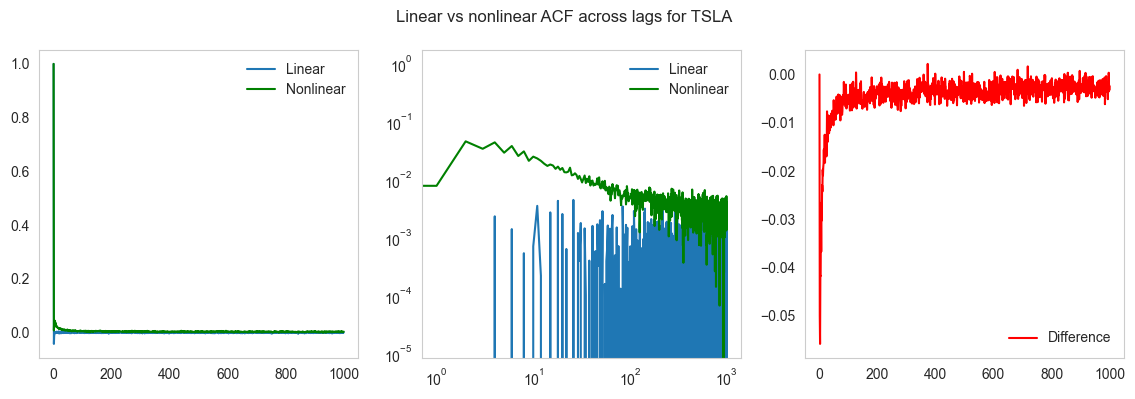

TSLA Max difference: 0.002191253828357338


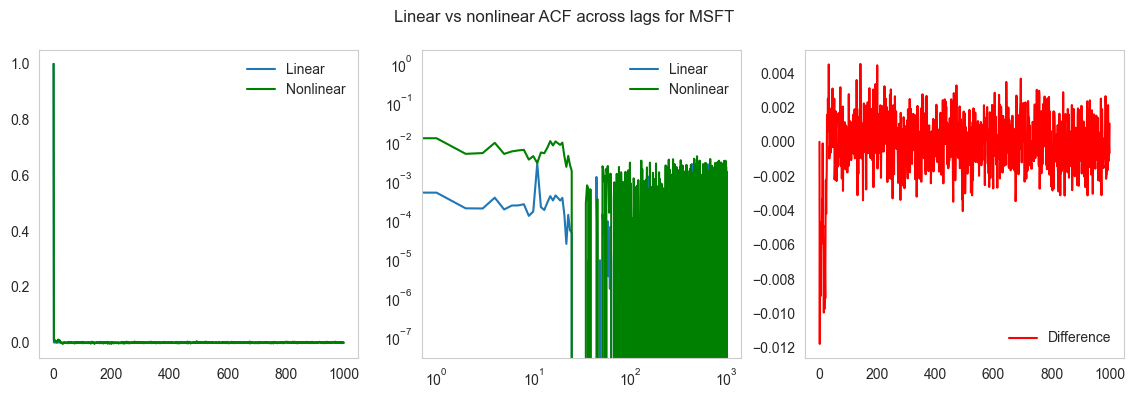

MSFT Max difference: 0.004544359791914785


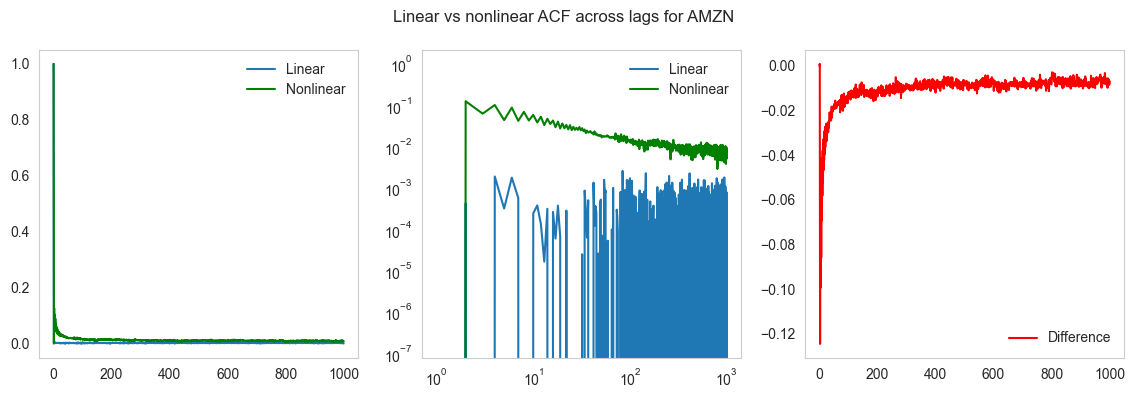

AMZN Max difference: 0.0007764100825211004


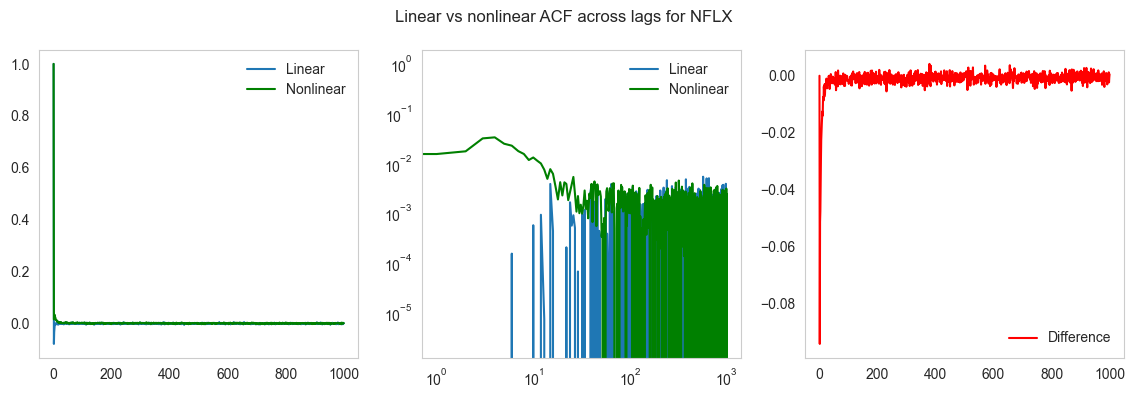

NFLX Max difference: 0.004157649051053626


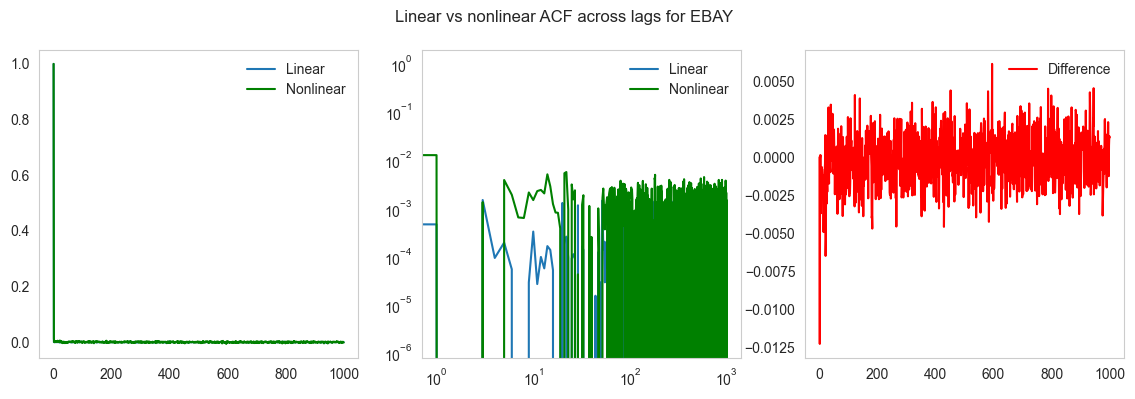

EBAY Max difference: 0.006118431182828775


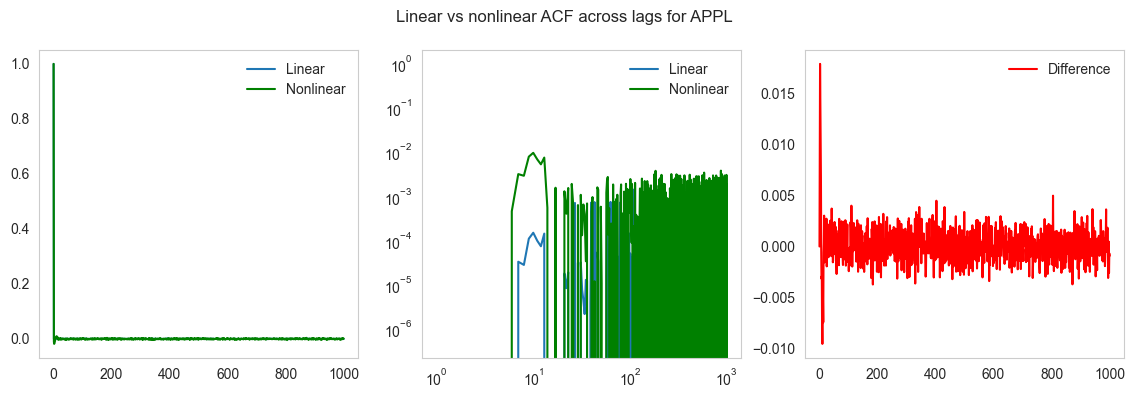

APPL Max difference: 0.017837362193398324


In [10]:
# Plot differences
# plot_acf_difference("TSLA", linear_acfs, nonlinear_acfs)
for stock_name in linear_acfs.keys():
    plot_acf_difference(stock_name, linear_acfs, nonlinear_acfs)

### 1.3. The Long Memory of Returns?

To determine if a random process exhibits long memory, we take the following approach:

1. **Infer an Autocorrelation Function (ACF):** Start by inferring the ACF from a finite return sample.

2. **Fit a Power-law to the ACF:** Use the inferred ACF to fit a power-law.

3. **Estimate Hurst Exponent:** Use standard and generalized hurst on cumulative sum of raw series.

#### 1.3.1. Estimate ACF scaling parameter

In [11]:
# TSLA Example
tsla_returns_acf = nonlinear_acfs['TSLA']
x = list(range(1, len(tsla_returns_acf) + 1))
xy_df = pd.DataFrame({"x_values": x, "y_values": tsla_returns_acf})

tsla_acf_fit = Fit(xy_df)
tsla_acf_fit.powerlaw.fit_results()


For powerlaw fitted using MLE:

Pre-fitting parameters;
xmin_index: 10
xmin: 11.0

Fitting parameters;
param_names = ['C', 'alpha']
C = 0.05937442858422154
alpha = -0.48203716108563416

Goodness of fit to data;
D = 0.16347124117053483
bic = -13213.369809732796
mape = 43.763592397863306
Adjusted R-squared = 0.7388713631119204




#### 1.3.2. For all assets

In [12]:
# Load the pre-computed ACFs
return_acf_values = {}

for stock, data in nonlinear_acfs.items():
    return_acf_values[stock] = construct_xy(data, stock)

In [13]:
# Using return_acf_values
fit_results_list = []
fit_objects = {}  # Dictionary to store fit objects

for stock, data in return_acf_values.items():
    fit_dict, fit_obj = get_acf_params(stock, data, xmin_index=10)
    if fit_dict:
        fit_results_list.append(fit_dict)
        fit_objects[stock] = fit_obj  # Store the fit object

acf_fit_results = pd.DataFrame(fit_results_list)
display(acf_fit_results.head())

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,gamma,stock
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0593744...",10,11.0,0.163471,-13213.369810,43.763592,0.738871,-0.482037,TSLA
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.9547797...",10,11.0,0.512614,-12848.904790,111.786929,0.127805,-1.950100,MSFT
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.1049572...",10,11.0,0.153380,-12233.072091,16.164657,0.826120,-0.410320,AMZN
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0333774...",10,11.0,0.347124,-13307.693549,455.716391,0.252519,-0.662197,NFLX
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0225642...",10,11.0,0.473259,-12633.913158,114.758413,0.016503,-0.948325,EBAY


In [14]:
fit_objects.keys()

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])

In [15]:
avg_gamma = acf_fit_results['gamma'].mean()
print(f"Average Gamma: {avg_gamma}")

Average Gamma: -0.7251185359660647


In [16]:
# Retrieve the fit object for 'STOCK':
# tsla_acf_fit = fit_objects['AMZN']
# tsla_acf_fit.powerlaw.plot_fit()

### 1.4. Estimate Hurst Exponent

The Hurst Exponent, denoted by $H$, is a statistical measure of a time series which can be used to determine the nature of the series. Its value can range between 0 and 1:

- $H = 0.5$: The series is a random walk (Brownian motion). The future values do not depend on the past values.

- $H < 0.5$: The series has a tendency to revert to a mean, indicating negative autocorrelation. This is typical of "mean-reverting" series.

- $H > 0.5$: The series shows a trending behavior, meaning that increases (decreases) in the past will likely be followed by increases (decreases) in the future.

In [17]:
# TSLA Example
tsla_returns = compute_returns(tsla_raw_df)['returns'].cumsum()

# Estimate Hurst Exponent using both Standard and Generalized metod
hurst_std, fit_std = standard_hurst(tsla_returns)
hurst_gen, fit_gen = generalized_hurst(tsla_returns)

fit_std.powerlaw.fit_results()
fit_gen.powerlaw.fit_results()

print(f"Standard Hurst Exponent: {hurst_std} ({interpret_hurst(hurst_std)})")
print(f"Generalized Hurst Exponent: {hurst_gen} ({interpret_hurst(hurst_gen)})")


For powerlaw fitted using MLE:

Pre-fitting parameters;
xmin_index: 1
xmin: 1.0

Fitting parameters;
param_names = ['C', 'alpha']
C = 0.049423308085641784
alpha = 0.5014366186494351

Goodness of fit to data;
D = 0.010678391959798994
bic = -22918.357788248246
mape = 0.2168627987275261
Adjusted R-squared = 0.9999583313461854



For powerlaw fitted using MLE:

Pre-fitting parameters;
xmin_index: 1
xmin: 1.0

Fitting parameters;
param_names = ['C', 'alpha']
C = 0.015725773148465426
alpha = 0.5681705528454868

Goodness of fit to data;
D = 0.010678391959798994
bic = -22262.11894403039
mape = 1.1741971735050782
Adjusted R-squared = 0.9997002159860406


Standard Hurst Exponent: 0.5014366186494351 (Super-diffusive: series demonstrates persistent long-range dependence)
Generalized Hurst Exponent: 0.5681705528454868 (Super-diffusive: series demonstrates persistent long-range dependence)


#### 1.4.1 For all assets

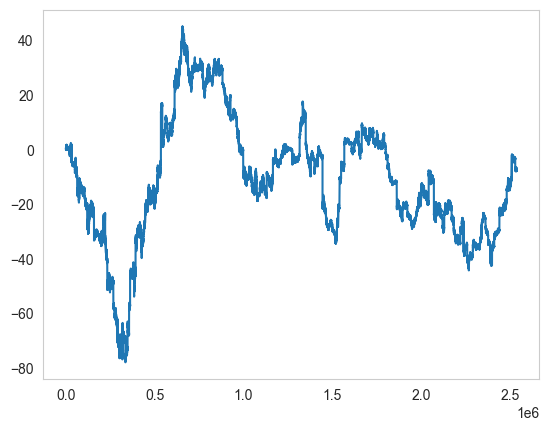

In [18]:
# Compute cumsum of returns as input for Hurst
tsla_cum_returns = compute_returns(tsla_raw_df)['returns']
amzn_cum_returns = compute_returns(msft_raw_df)['returns']
nflx_cum_returns = compute_returns(amzn_raw_df)['returns']
msft_cum_returns = compute_returns(nflx_raw_df)['returns']
ebay_cum_returns = compute_returns(ebay_raw_df)['returns']
appl_cum_returns = compute_returns(appl_raw_df)['returns']

cumsum_returns = {
  'TSLA': tsla_cum_returns.cumsum(),
  'MSFT': amzn_cum_returns.cumsum(),
  'AMZN': nflx_cum_returns.cumsum(),
  'NFLX': msft_cum_returns.cumsum(),
  'EBAY': ebay_cum_returns.cumsum(),
  'APPL': appl_cum_returns.cumsum()
}
# Update the dictionary to only keep the first EVENTS_RANGE items
cumsum_returns = {stock: data.head(EVENTS_RANGE) for stock, data in cumsum_returns.items()}
tsla_cumsum_returns = tsla_cum_returns = compute_returns(tsla_raw_df)['returns'].cumsum()
x = list(range(1, len(tsla_cum_returns)+1))
plt.plot(x, tsla_cum_returns)
plt.grid(False)
plt.show()

#### Standard Hurst

In [19]:
# Standard Hurst
method = 'standard'
fit_results_list = []
fit_objects = {}

for stock, data in cumsum_returns.items():
    fit_dict, fit = compute_hurst_exponent('returns', stock, data, method=method, max_lag=LAG)
    if fit_dict:
        fit_results_list.append(fit_dict)
        fit_objects[(stock, method, 'returns')] = fit

std_hurst_fit_results = pd.DataFrame(fit_results_list)
display(std_hurst_fit_results.head())

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,standard_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0665403...",1,2.0,0.019830,-5426.084093,1.244771,0.997828,0.488711,TSLA,returns
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0053901...",1,2.0,0.008499,-10265.164302,0.431657,0.999678,0.494441,MSFT,returns
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.2270582...",1,2.0,0.008499,-4547.681810,0.570995,0.999420,0.496274,AMZN,returns
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0148636...",1,2.0,0.016997,-7446.003086,1.170524,0.997654,0.492765,NFLX,returns
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0047727...",1,2.0,0.008499,-10756.789623,0.408550,0.999807,0.497981,EBAY,returns


In [20]:
# Average Standard Hurst exponents across stocks
avg_hurst_std = std_hurst_fit_results['standard_hurst'].mean()
print(f"Average Standard Hurst: {avg_hurst_std}")

Average Standard Hurst: 0.4949346932000836


In [21]:
print(fit_objects.keys())

dict_keys([('TSLA', 'standard', 'returns'), ('MSFT', 'standard', 'returns'), ('AMZN', 'standard', 'returns'), ('NFLX', 'standard', 'returns'), ('EBAY', 'standard', 'returns'), ('APPL', 'standard', 'returns')])


In [22]:
# Retrieve standard Hurst fit object for specific 'STOCK'
# tsla_standard_fit = fit_objects[('TSLA', 'standard', 'returns')]
# tsla_standard_fit.powerlaw.plot_fit()

#### Generalized Hurst

In [23]:
# Generalized Hurst
method = 'generalized'
fit_results_list = []
fit_objects = {}

for stock, data in cumsum_returns.items():
    fit_dict, fit = compute_hurst_exponent('returns', stock, data, method=method,  max_lag=LAG)
    if fit_dict:
        fit_results_list.append(fit_dict)
        fit_objects[(stock, method, 'returns')] = fit

gen_hurst_fit_results = pd.DataFrame(fit_results_list)
display(gen_hurst_fit_results.head())

/Users/ana_bugaenko/workspace/powerlaw_function/util/goodness_of_fit.py:152: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  result = stats.ks_2samp(y_values, model_predictions, alternative="two-sided")


,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,generalized_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0181530...",1,2.0,0.008499,-8147.285091,0.683901,0.999880,0.597048,TSLA,returns
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0007694...",1,2.0,0.021246,-11916.696197,1.719034,0.999437,0.559441,MSFT,returns
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0115843...",1,2.0,0.011331,-6548.780024,1.776336,0.999599,0.729641,AMZN,returns
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0075549...",1,2.0,0.012748,-9630.569879,0.761413,0.999772,0.531532,NFLX,returns
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0004536...",1,2.0,0.005666,-13140.575666,0.951108,0.999918,0.642814,EBAY,returns


In [24]:
# Generalized Hurst statistic across stocks
min_hurst_gen = gen_hurst_fit_results['generalized_hurst'].min()
max_hurst_gen = gen_hurst_fit_results['generalized_hurst'].max()
avg_hurst_gen = gen_hurst_fit_results['generalized_hurst'].mean()
standard_dev = gen_hurst_fit_results['generalized_hurst'].std()

print(f"Min Generalized Hurst: {min_hurst_gen}")
print(f"Max Generalized Hurst: {max_hurst_gen}")
print(f"Average Generalized Hurst: {avg_hurst_gen}")
print(f"Standard_dev Generalized Hurst: {standard_dev}")

Min Generalized Hurst: 0.5315317573665245
Max Generalized Hurst: 0.729640880404383
Average Generalized Hurst: 0.6110075584631994
Standard_dev Generalized Hurst: 0.06969285396038993


In [25]:
print(fit_objects.keys())

dict_keys([('TSLA', 'generalized', 'returns'), ('MSFT', 'generalized', 'returns'), ('AMZN', 'generalized', 'returns'), ('NFLX', 'generalized', 'returns'), ('EBAY', 'generalized', 'returns'), ('APPL', 'generalized', 'returns')])


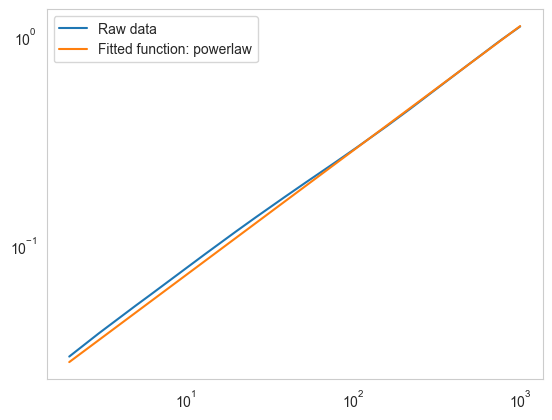

In [26]:
# Retrieve generalized fit object for specific 'STOCK'
tsla_generalized_fit = fit_objects[('TSLA', 'generalized', 'returns')]
tsla_generalized_fit.powerlaw.plot_fit()

## 2. Percentage Returns

In [27]:
# Compute percentage returns
tsla_percentage_returns = compute_returns(tsla_raw_df)['pct_returns']
msft_percentage_returns = compute_returns(msft_raw_df)['pct_returns']
amzn_percentage_returns = compute_returns(amzn_raw_df)['pct_returns']
nflx_percentage_returns = compute_returns(nflx_raw_df)['pct_returns']
ebay_percentage_returns = compute_returns(ebay_raw_df)['pct_returns']
appl_percentage_returns = compute_returns(appl_raw_df)['pct_returns']

percentage_returns = {
  'TSLA': tsla_percentage_returns,
  'MSFT': msft_percentage_returns,
  'AMZN': amzn_percentage_returns,
  'NFLX': nflx_percentage_returns,
  'EBAY': ebay_percentage_returns,
  'APPL': appl_percentage_returns
}
# Update the dictionary to only keep the first EVENTS_RANGE items
percentage_returns = {stock: data.head(EVENTS_RANGE) for stock, data in percentage_returns.items()}

### Stationarity Test

In [28]:
# ADF test
for stock, data in percentage_returns.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)

TSLA
ADF: -418.87
p-value: 0.00,
N: 499997, 
critical values: {'1%': -3.4303630787456174, '5%': -2.8615457806516207, '10%': -2.5667730768296972}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


MSFT
ADF: -706.73
p-value: 0.00,
N: 499999, 
critical values: {'1%': -3.430363078693302, '5%': -2.861545780628498, '10%': -2.5667730768173898}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


AMZN
ADF: -707.32
p-value: 0.00,
N: 499999, 
critical values: {'1%': -3.430363078693302, '5%': -2.861545780628498, '10%': -2.5667730768173898}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


NFLX
ADF: -166.66
p-value: 0.00,
N: 499981, 
critical values: {'1%': -3.430363079164155, '5%': -2.861545780836609, '10%': -2.56677307692816}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.




### 2.1. Percentage returns ACF

In [29]:
# Linear ACF
percentage_returns_linear_acf_filename = f"{acf_data_dir}/lo_percentage_returns_linear_acfs.pkl"
percentage_returns_linear_acfs = compute_acfs(filename=percentage_returns_linear_acf_filename, data=percentage_returns, option='linear')
print(percentage_returns_linear_acfs.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])


In [30]:
# Nonlinear ACF
percentage_returns_nonlinear_acf_filename = f"{acf_data_dir}/lo_percentage_returns_nonlinear_acfs.pkl"
percentage_returns_nonlinear_acfs = compute_acfs(filename=percentage_returns_nonlinear_acf_filename, data=percentage_returns, option='nonlinear')
print(percentage_returns_nonlinear_acfs.keys())

/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5218: RuntimeWarning: overflow encountered in scalar multiply
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5218: RuntimeWarning: overflow encountered in scalar multiply
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5218: RuntimeWarning: overflow encountered in scalar multiply
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5218: RuntimeWarning: overflow encountered in scalar multiply
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5218: RuntimeWarning: overflow encountered in scalar multipl

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])


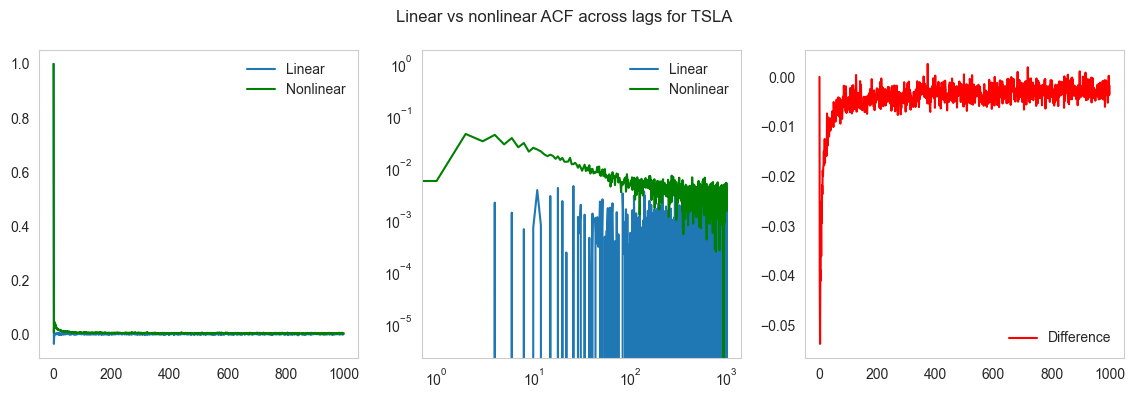

TSLA Max difference: 0.002621406523831404


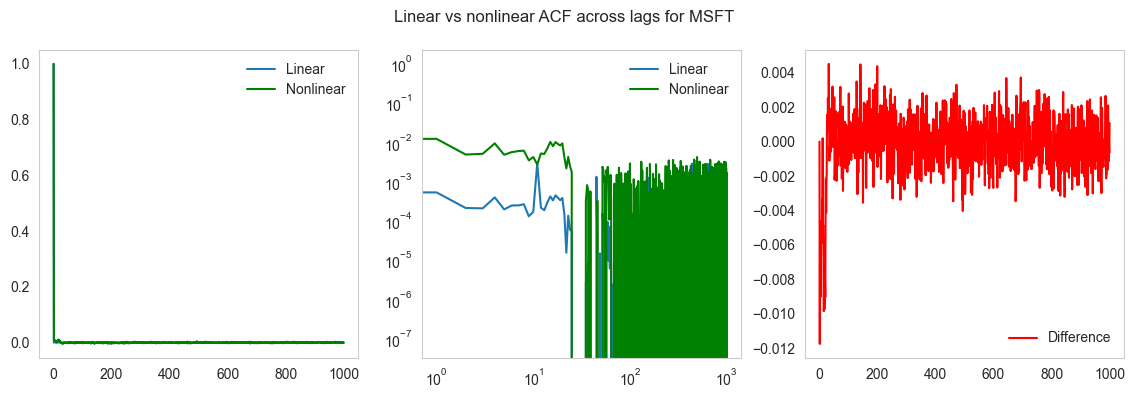

MSFT Max difference: 0.004516003891420137


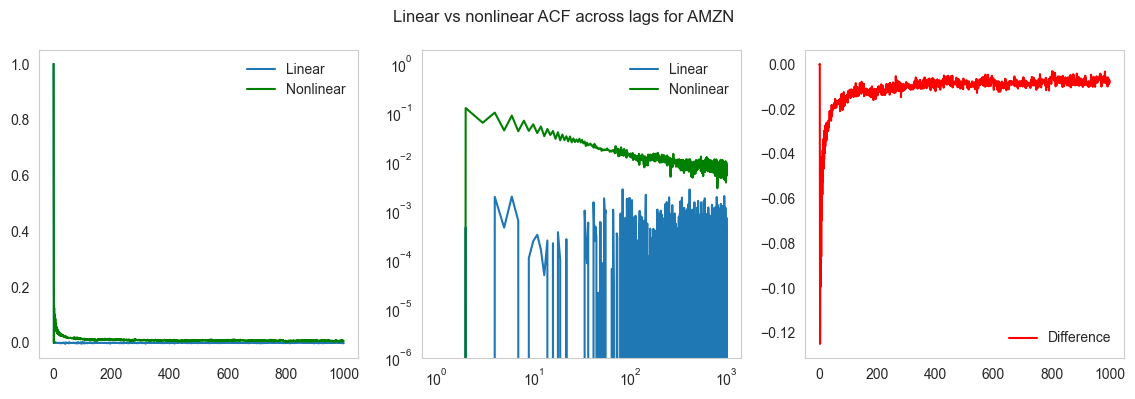

AMZN Max difference: 0.00023711574652004585


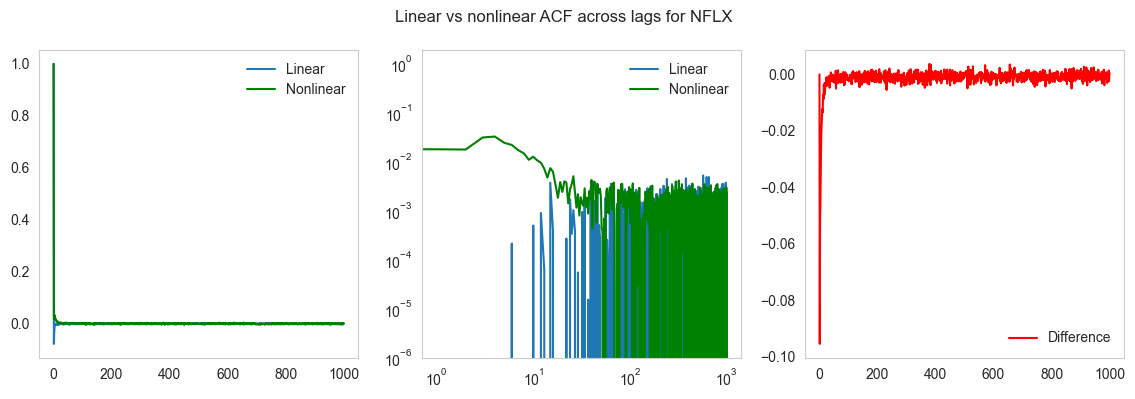

NFLX Max difference: 0.0037313897516559245


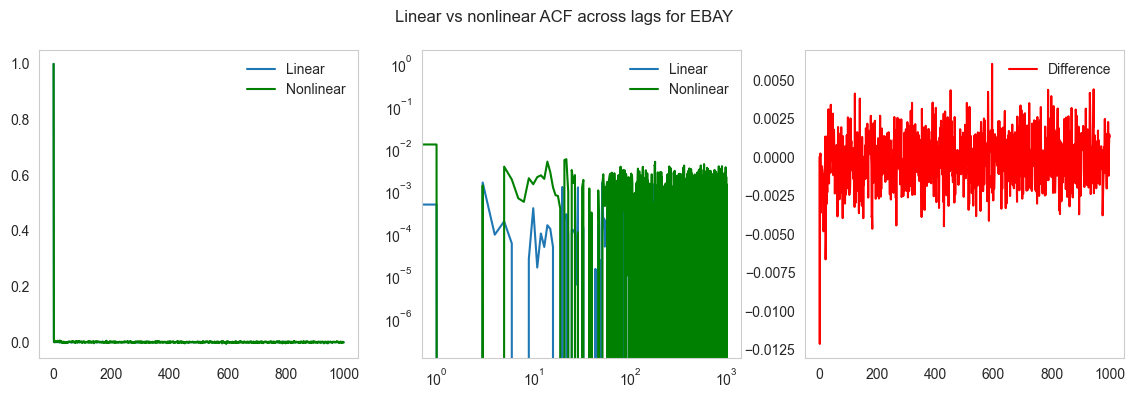

EBAY Max difference: 0.0060444159902202045


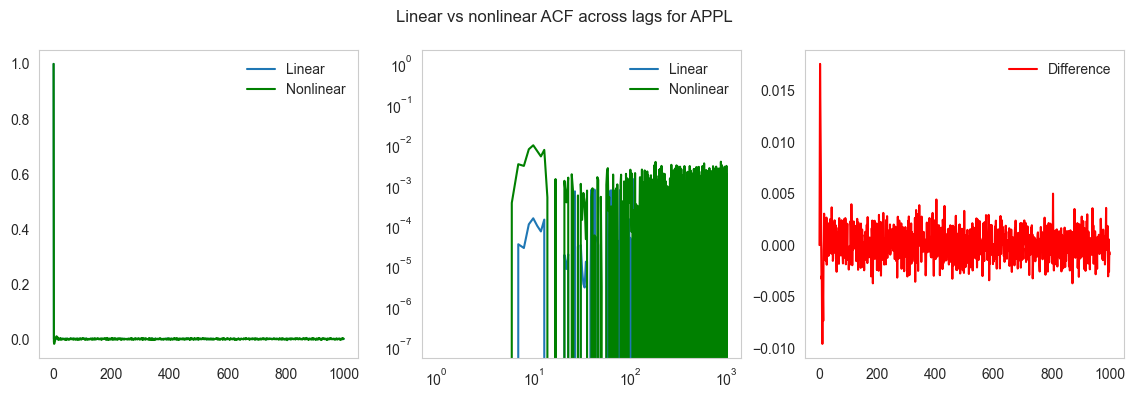

APPL Max difference: 0.01759224087510748


In [31]:
for stock_name in percentage_returns_linear_acfs.keys():
    plot_acf_difference(stock_name, percentage_returns_linear_acfs, percentage_returns_nonlinear_acfs)

### 2.2. Fit power law to percentage returns ACF

In [32]:
# Load the pre-computed ACFs
percentage_returns_acf_values = {}

for stock, data in percentage_returns_nonlinear_acfs.items():
    percentage_returns_acf_values[stock] = construct_xy(data, stock)

In [33]:
# Using percentage_return_acf_values
percentage_returns_fit_list = []
percentage_returns_fit_objects = {}

for stock, data in percentage_returns_acf_values.items():
    fit_dict, fit_obj = get_acf_params(stock, data, xmin_index=10)
    if fit_dict:
        percentage_returns_fit_list.append(fit_dict)
        percentage_returns_fit_objects[stock] = fit_obj  # Store the fit object

percentage_returns_fit_results = pd.DataFrame(percentage_returns_fit_list)
display(percentage_returns_fit_results.head())

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,gamma,stock
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0568866...",10,11.0,0.170535,-13258.437038,38.062430,0.737297,-0.476021,TSLA
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.9417548...",10,11.0,0.512614,-12854.447297,105.847115,0.126983,-1.947332,MSFT
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.1033239...",10,11.0,0.154390,-12217.132975,16.051877,0.821848,-0.405715,AMZN
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0299790...",10,11.0,0.353179,-13386.982308,274.928840,0.251423,-0.638429,NFLX
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0222102...",10,11.0,0.475277,-12658.473454,123.557196,0.017037,-0.943536,EBAY


In [34]:
percentage_returns_fit_objects.keys()

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])

In [35]:
avg_alpha = percentage_returns_fit_results['gamma'].mean()
print(f"Average Gamma: {avg_alpha}")

Average Gamma: -0.7197179212042979


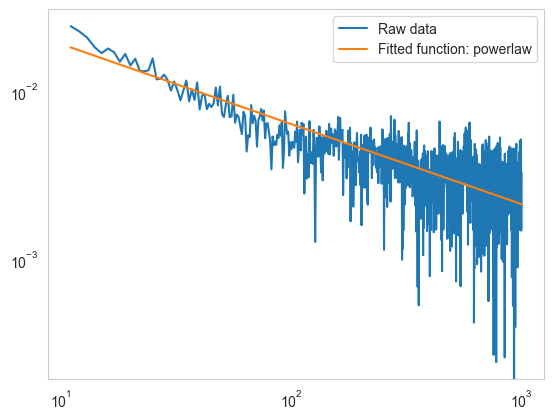

In [36]:
tsla_acf_fit = percentage_returns_fit_objects['TSLA']
tsla_acf_fit.powerlaw.plot_fit()

### 2.3 Percentage returns Hurst Exponents

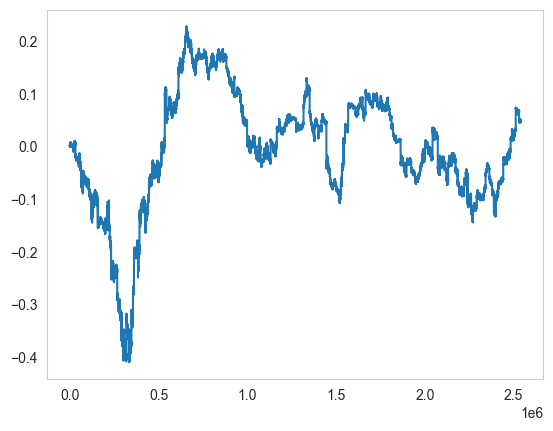

In [37]:
# Compute cumsum of percentage returns
cumsum_percentage_returns = {
  'TSLA': tsla_percentage_returns.cumsum(),
  'MSFT': msft_percentage_returns.cumsum(),
  'AMZN': amzn_percentage_returns.cumsum(),
  'NFLX': nflx_percentage_returns.cumsum(),
  'EBAY': ebay_percentage_returns.cumsum(),
  'APPL': appl_percentage_returns.cumsum()
}
# Update the dictionary to only keep the first EVENTS_RANGE items
cumsum_percentage_returns = {stock: data.head(EVENTS_RANGE) for stock, data in cumsum_percentage_returns.items()}
tsla_cumsum_percentage_returns = tsla_percentage_returns.cumsum()
x = list(range(1, len(tsla_cumsum_percentage_returns)+1))
plt.plot(x, tsla_cumsum_percentage_returns)
plt.grid(False)
plt.show()

#### Standard Hurst

In [38]:
# Standard Hurst
method = 'standard'
percentage_returns_fit_results_list = []
percentage_returns_fit_objects = {}

for stock, data in cumsum_percentage_returns.items():
    fit_dict, fit = compute_hurst_exponent('percentage_returns', stock, data, method=method, max_lag=LAG)
    if fit_dict:
        percentage_returns_fit_results_list.append(fit_dict)
        percentage_returns_fit_objects[(stock, method, 'percentage_returns')] = fit

percentage_returns_std_hurst_fit_results = pd.DataFrame(percentage_returns_fit_results_list)
display(percentage_returns_std_hurst_fit_results.head())

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,standard_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0003828...",1,2.0,0.016997,-12704.680924,1.281090,0.997785,0.487817,TSLA,percentage_returns
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0001022...",1,2.0,0.008499,-15836.048619,0.437663,0.999665,0.494446,MSFT,percentage_returns
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0004035...",1,2.0,0.009915,-13423.446960,0.624143,0.999348,0.494790,AMZN,percentage_returns
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0001309...",1,2.0,0.016997,-14146.721034,1.141204,0.997739,0.493446,NFLX,percentage_returns
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0001844...",1,2.0,0.009915,-15270.069276,0.441489,0.999781,0.497257,EBAY,percentage_returns


In [39]:
# Average Standard Hurst exponents across stocks
avg_hurst_std = percentage_returns_std_hurst_fit_results['standard_hurst'].mean()
print(f"Average Standard Hurst: {avg_hurst_std}")

Average Standard Hurst: 0.4945322584656666


In [40]:
display(percentage_returns_fit_objects.keys())

dict_keys([('TSLA', 'standard', 'percentage_returns'), ('MSFT', 'standard', 'percentage_returns'), ('AMZN', 'standard', 'percentage_returns'), ('NFLX', 'standard', 'percentage_returns'), ('EBAY', 'standard', 'percentage_returns'), ('APPL', 'standard', 'percentage_returns')])

#### Generalized Hurst

In [41]:
# Generalized Hurst
method = 'generalized'
percentage_returns_fit_results_list = []
percentage_returns_fit_objects = {}

for stock, data in cumsum_percentage_returns.items():
    fit_dict, fit = compute_hurst_exponent('percentage_returns', stock, data, method=method, max_lag=LAG)
    if fit_dict:
        percentage_returns_fit_results_list.append(fit_dict)
        percentage_returns_fit_objects[(stock, method, 'percentage_returns')] = fit

percentage_returns_gen_hurst_fit_results = pd.DataFrame(percentage_returns_fit_results_list)
display(percentage_returns_gen_hurst_fit_results.head(10))

/Users/ana_bugaenko/workspace/powerlaw_function/util/goodness_of_fit.py:152: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  result = stats.ks_2samp(y_values, model_predictions, alternative="two-sided")
/Users/ana_bugaenko/workspace/powerlaw_function/util/goodness_of_fit.py:152: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  result = stats.ks_2samp(y_values, model_predictions, alternative="two-sided")


,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,generalized_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 9.7784501...",1,2.0,0.007082,-15587.220820,0.637109,0.999895,0.599662,TSLA,percentage_returns
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1.5070235...",1,2.0,0.021246,-17502.003018,1.708736,0.999452,0.558214,MSFT,percentage_returns
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1.9290033...",1,2.0,0.011331,-15492.369610,1.841086,0.999565,0.732867,AMZN,percentage_returns
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 6.6768451...",1,2.0,0.012748,-16308.710288,0.762827,0.999773,0.531841,NFLX,percentage_returns
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1.8282792...",1,2.0,0.005666,-17721.381599,0.953495,0.999921,0.640929,EBAY,percentage_returns
5,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 5.7604063...",1,2.0,0.011331,-19296.656846,0.807248,0.999854,0.605185,APPL,percentage_returns


In [42]:
# Generalized Hurst statistic across stocks
min_hurst_gen = percentage_returns_gen_hurst_fit_results['generalized_hurst'].min()
max_hurst_gen = percentage_returns_gen_hurst_fit_results['generalized_hurst'].max()
avg_hurst_gen = percentage_returns_gen_hurst_fit_results['generalized_hurst'].mean()
standard_dev = percentage_returns_gen_hurst_fit_results['generalized_hurst'].std()

print(f"Min Generalized Hurst: {min_hurst_gen}")
print(f"Max Generalized Hurst: {max_hurst_gen}")
print(f"Average Generalized Hurst: {avg_hurst_gen}")
print(f"Standard_dev Generalized Hurst: {standard_dev}")

Min Generalized Hurst: 0.5318405163090878
Max Generalized Hurst: 0.7328665194367603
Average Generalized Hurst: 0.6114495528692769
Standard_dev Generalized Hurst: 0.07065545751540515


In [43]:
print(percentage_returns_fit_objects.keys())

dict_keys([('TSLA', 'generalized', 'percentage_returns'), ('MSFT', 'generalized', 'percentage_returns'), ('AMZN', 'generalized', 'percentage_returns'), ('NFLX', 'generalized', 'percentage_returns'), ('EBAY', 'generalized', 'percentage_returns'), ('APPL', 'generalized', 'percentage_returns')])


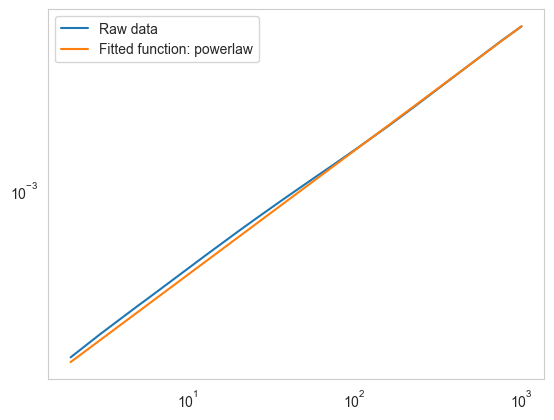

In [44]:
# Retrieve generalized fit object for specific 'STOCK'
tsla_generalized_fit = percentage_returns_fit_objects[('TSLA', 'generalized', 'percentage_returns')]
tsla_generalized_fit.powerlaw.plot_fit()

## 3. Log Returns

In [45]:
# Compute log returns
tsla_log_returns = compute_returns(tsla_raw_df)['log_returns']
msft_log_returns = compute_returns(msft_raw_df)['log_returns']
amzn_log_returns = compute_returns(amzn_raw_df)['log_returns']
nflx_log_returns = compute_returns(nflx_raw_df)['log_returns']
ebay_log_returns = compute_returns(ebay_raw_df)['log_returns']
appl_log_returns = compute_returns(appl_raw_df)['log_returns']

log_returns = {
  'TSLA': tsla_log_returns,
  'MSFT': msft_log_returns,
  'AMZN': amzn_log_returns,
  'NFLX': nflx_log_returns,
  'EBAY': ebay_log_returns,
  'APPL': appl_log_returns
}
# Update the dictionary to only keep the first EVENTS_RANGE items
log_returns = {stock: data.head(EVENTS_RANGE) for stock, data in log_returns.items()}

### Stationarity Test

In [46]:
# ADF test
for stock, data in log_returns.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)

TSLA
ADF: -418.94
p-value: 0.00,
N: 499996, 
critical values: {'1%': -3.430363078771775, '5%': -2.861545780663182, '10%': -2.566773076835851}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


MSFT
ADF: -706.75
p-value: 0.00,
N: 499998, 
critical values: {'1%': -3.4303630787194597, '5%': -2.8615457806400593, '10%': -2.5667730768235435}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


AMZN
ADF: -707.17
p-value: 0.00,
N: 499998, 
critical values: {'1%': -3.4303630787194597, '5%': -2.8615457806400593, '10%': -2.5667730768235435}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


NFLX
ADF: -166.69
p-value: 0.00,
N: 499980, 
critical values: {'1%': -3.4303630791903146, '5%': -2.861545780848171, '10%': -2.566773076934314}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.

### 3.1. Log returns ACF

In [47]:
# Linear ACF
log_returns_linear_acf_filename = f"{acf_data_dir}/lo_log_returns_linear_acfs.pkl"
log_returns_linear_acfs = compute_acfs(filename=log_returns_linear_acf_filename, data=log_returns, option='linear')
print(log_returns_linear_acfs.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])


In [48]:
# Nonlinear ACF
log_returns_nonlinear_acf_filename = f"{acf_data_dir}/lo_log_returns_nonlinear_acfs.pkl"
log_returns_nonlinear_acfs = compute_acfs(filename=log_returns_nonlinear_acf_filename, data=log_returns, option='nonlinear')
print(log_returns_nonlinear_acfs.keys())

/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5218: RuntimeWarning: overflow encountered in scalar multiply
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5218: RuntimeWarning: overflow encountered in scalar multiply
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5218: RuntimeWarning: overflow encountered in scalar multiply
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5218: RuntimeWarning: overflow encountered in scalar multiply
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5218: RuntimeWarning: overflow encountered in scalar multipl

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])


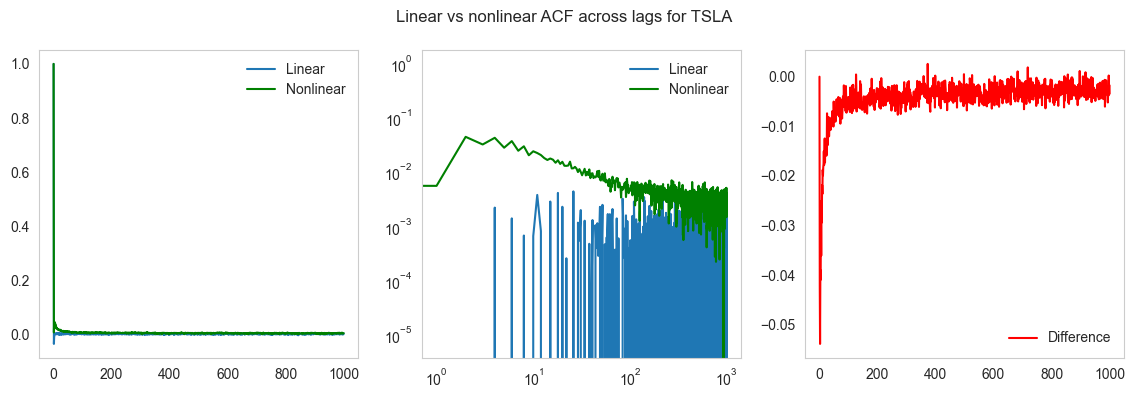

TSLA Max difference: 0.002577414817237301


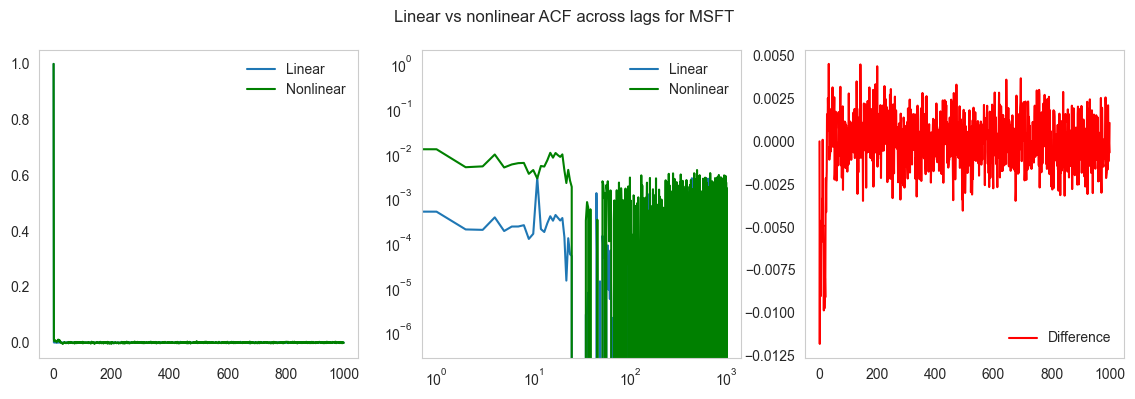

MSFT Max difference: 0.004530544041714334


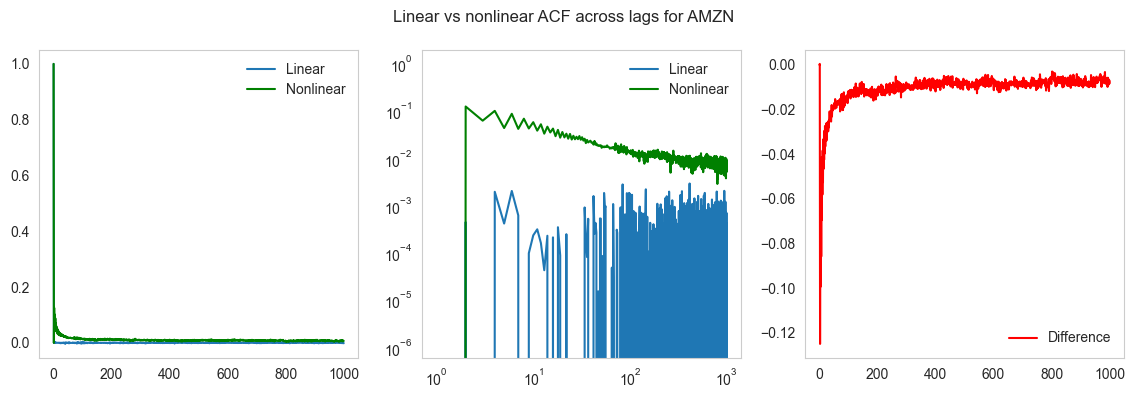

AMZN Max difference: 0.00040347964178807005


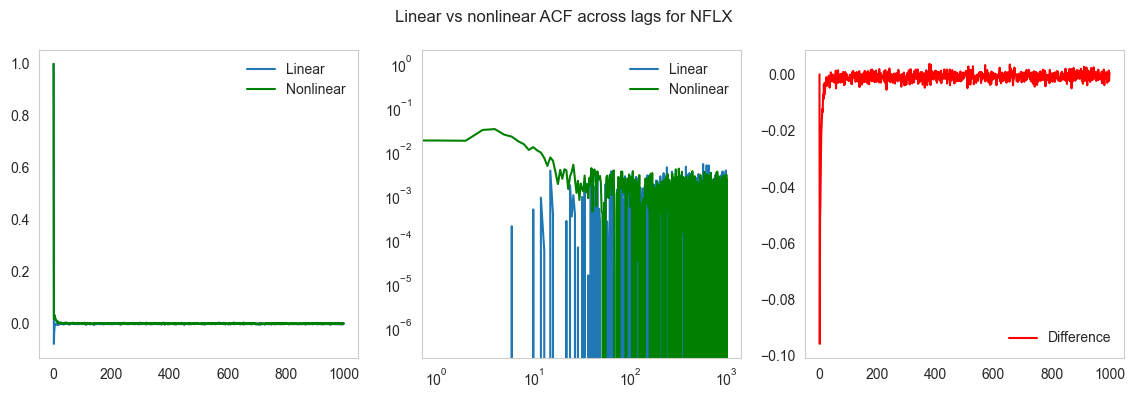

NFLX Max difference: 0.0036994216241744253


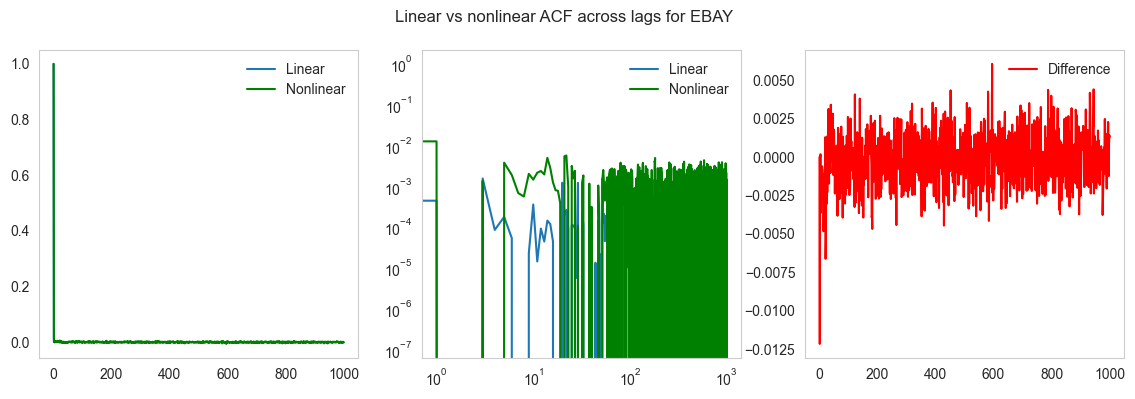

EBAY Max difference: 0.006067002925476669


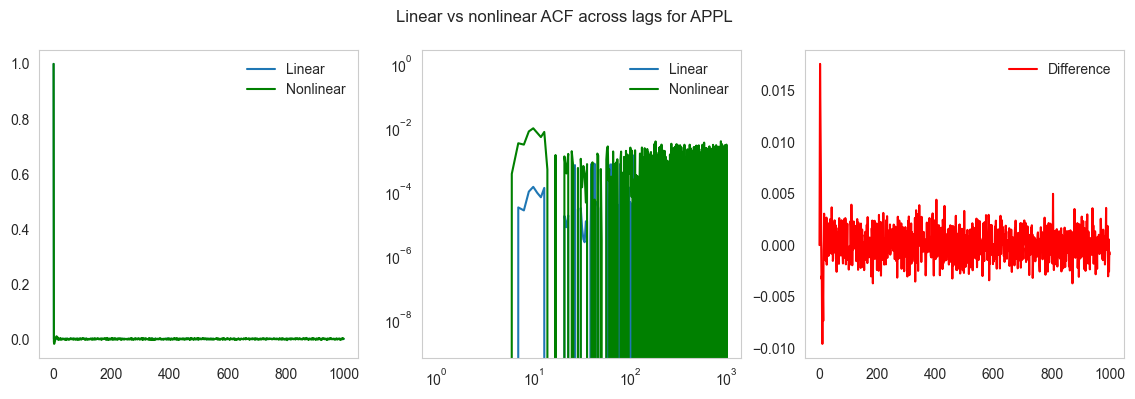

APPL Max difference: 0.017611373963695807


In [49]:
for stock_name in log_returns_linear_acfs.keys():
    plot_acf_difference(stock_name, log_returns_linear_acfs, log_returns_nonlinear_acfs)

### 3.2. Fit power law to log retrurns ACF

In [50]:
# Load the pre-computed ACFs
log_returns_acf_values = {}

for stock, data in log_returns_nonlinear_acfs.items():
    log_returns_acf_values[stock] = construct_xy(data, stock)

In [51]:
# Using log_returns_nonlinear_acfs
log_returns_fit_results_list = []
log_returns_fit_objects = {}  # Dictionary to store fit objects

for stock, data in log_returns_acf_values.items():
    fit_dict, fit_obj = get_acf_params(stock, data, xmin_index=10)
    if fit_dict:
        log_returns_fit_results_list.append(fit_dict)
        log_returns_fit_objects[stock] = fit_obj  # Store the fit object

log_returns_fit_results = pd.DataFrame(log_returns_fit_results_list)
display(log_returns_fit_results.head(10))

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,gamma,stock
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0569214...",10,11.0,0.167508,-13258.942254,38.145594,0.737489,-0.476224,TSLA
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.9402292...",10,11.0,0.512614,-12854.142598,105.816518,0.127081,-1.946502,MSFT
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.1034062...",10,11.0,0.154390,-12216.829648,16.066498,0.821889,-0.405887,AMZN
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0299884...",10,11.0,0.353179,-13386.921909,438.128303,0.251484,-0.638466,NFLX
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0222089...",10,11.0,0.475277,-12658.470885,123.492075,0.017037,-0.943528,EBAY
5,powerlaw,"{'param_names': ['C', 'alpha'], 'C': -3.197094...",10,11.0,0.502523,-12914.600187,110.939539,-0.002985,0.092726,APPL


In [52]:
log_returns_fit_objects.keys()

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])

In [53]:
avg_alpha = log_returns_fit_results['gamma'].mean()
print(f"Average Gamma: {avg_alpha}")

Average Gamma: -0.7196468891834282


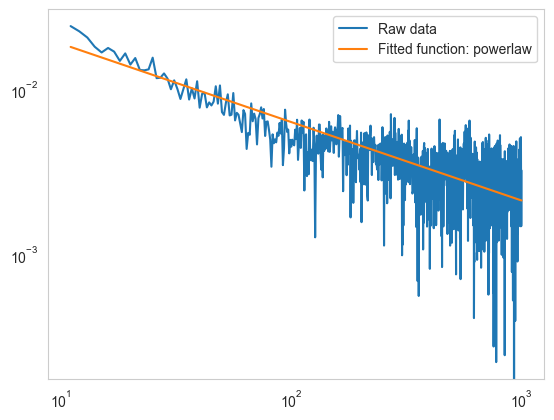

In [54]:
tsla_acf_fit = log_returns_fit_objects['TSLA']
tsla_acf_fit.powerlaw.plot_fit()

### 3.3. Log returns Hurst Exponents

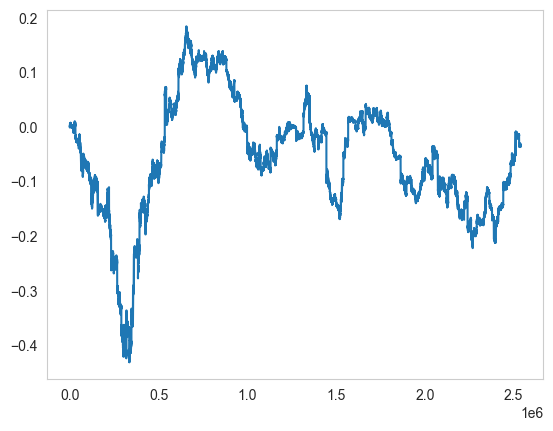

In [55]:
cumsum_log_returns = {
  'TSLA': tsla_log_returns.cumsum(),
  'MSFT': msft_log_returns.cumsum(),
  'AMZN': amzn_log_returns.cumsum(),
  'NFLX': nflx_log_returns.cumsum(),
  'EBAY': ebay_log_returns.cumsum(),
  'APPL': appl_log_returns.cumsum()
}
# Update the dictionary to only keep the first EVENTS_RANGE items
cumsum_log_returns = {stock: data.head(EVENTS_RANGE) for stock, data in cumsum_log_returns.items()}
tsla_cumsum_log_returns = compute_returns(tsla_raw_df)['log_returns'].cumsum()
x = list(range(1, len(tsla_cumsum_log_returns)+1))
plt.plot(x, tsla_cumsum_log_returns)
plt.grid(False)
plt.show()

#### Standard Hurst

In [56]:
# Standard Hurst
method = 'standard'
log_returns_fit_results_list = []
log_returns_fit_objects = {}

for stock, data in cumsum_log_returns.items():
    fit_dict, fit = compute_hurst_exponent('log_returns', stock, data, method=method, max_lag=LAG)
    if fit_dict:
        log_returns_fit_results_list.append(fit_dict)
        log_returns_fit_objects[(stock, method, 'log_returns')] = fit

log_returns_std_hurst_fit_results = pd.DataFrame(log_returns_fit_results_list)
display(log_returns_std_hurst_fit_results.head(10))

/Users/ana_bugaenko/workspace/hurst_exponent/hurst_exponent/hurst_exponent.py:23: UserWarning: Time series contained NaN or Inf values. These values were removed.
  warnings.warn("Time series contained NaN or Inf values. These values were removed.")
/Users/ana_bugaenko/workspace/hurst_exponent/hurst_exponent/hurst_exponent.py:23: UserWarning: Time series contained NaN or Inf values. These values were removed.
  warnings.warn("Time series contained NaN or Inf values. These values were removed.")
/Users/ana_bugaenko/workspace/hurst_exponent/hurst_exponent/hurst_exponent.py:23: UserWarning: Time series contained NaN or Inf values. These values were removed.
  warnings.warn("Time series contained NaN or Inf values. These values were removed.")
/Users/ana_bugaenko/workspace/hurst_exponent/hurst_exponent/hurst_exponent.py:23: UserWarning: Time series contained NaN or Inf values. These values were removed.
  warnings.warn("Time series contained NaN or Inf values. These values were removed.")


,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,standard_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0003822...",1,2.0,0.016997,-12688.963830,1.300631,0.997716,0.487509,TSLA,log_returns
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0001056...",1,2.0,0.008499,-15822.449534,0.425219,0.999681,0.494614,MSFT,log_returns
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0004106...",1,2.0,0.009915,-13362.906684,0.640628,0.999316,0.494949,AMZN,log_returns
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0001304...",1,2.0,0.015581,-14166.552259,1.127753,0.997791,0.493578,NFLX,log_returns
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0001925...",1,2.0,0.008499,-15271.079453,0.421862,0.999800,0.497456,EBAY,log_returns
5,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 8.3643290...",1,2.0,0.007082,-17338.457178,0.195843,0.999945,0.499462,APPL,log_returns


In [57]:
# Average Standard Hurst exponents across stocks
avg_hurst_std = log_returns_std_hurst_fit_results['standard_hurst'].mean()
print(f"Average Standard Hurst: {avg_hurst_std}")

Average Standard Hurst: 0.49459451305278707


In [58]:
display(log_returns_fit_objects.keys())

dict_keys([('TSLA', 'standard', 'log_returns'), ('MSFT', 'standard', 'log_returns'), ('AMZN', 'standard', 'log_returns'), ('NFLX', 'standard', 'log_returns'), ('EBAY', 'standard', 'log_returns'), ('APPL', 'standard', 'log_returns')])

#### Generalized Hurst

In [59]:
# Generalized Hurst
method = 'generalized'
log_returns_fit_results_list = []
log_returns_fit_objects = {}

for stock, data in cumsum_log_returns.items():
    fit_dict, fit = compute_hurst_exponent('log_returns', stock, data, method=method, max_lag=LAG)
    if fit_dict:
        log_returns_fit_results_list.append(fit_dict)
        log_returns_fit_objects[(stock, method, 'log_returns')] = fit

log_returns_gen_hurst_fit_results = pd.DataFrame(log_returns_fit_results_list)
display(log_returns_gen_hurst_fit_results.head(10))

/Users/ana_bugaenko/workspace/hurst_exponent/hurst_exponent/hurst_exponent.py:23: UserWarning: Time series contained NaN or Inf values. These values were removed.
  warnings.warn("Time series contained NaN or Inf values. These values were removed.")
/Users/ana_bugaenko/workspace/hurst_exponent/hurst_exponent/hurst_exponent.py:23: UserWarning: Time series contained NaN or Inf values. These values were removed.
  warnings.warn("Time series contained NaN or Inf values. These values were removed.")
/Users/ana_bugaenko/workspace/hurst_exponent/hurst_exponent/hurst_exponent.py:23: UserWarning: Time series contained NaN or Inf values. These values were removed.
  warnings.warn("Time series contained NaN or Inf values. These values were removed.")
/Users/ana_bugaenko/workspace/hurst_exponent/hurst_exponent/hurst_exponent.py:23: UserWarning: Time series contained NaN or Inf values. These values were removed.
  warnings.warn("Time series contained NaN or Inf values. These values were removed.")


,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,generalized_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 9.7811605...",1,2.0,0.007082,-15587.233950,0.636591,0.999895,0.599546,TSLA,log_returns
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1.4953250...",1,2.0,0.021246,-17484.163380,1.708787,0.999447,0.560305,MSFT,log_returns
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1.9298713...",1,2.0,0.011331,-15493.635908,1.840122,0.999565,0.732671,AMZN,log_returns
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 6.6802719...",1,2.0,0.012748,-16308.587201,0.762412,0.999773,0.531700,NFLX,log_returns
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 1.8166652...",1,2.0,0.005666,-17707.216528,0.950510,0.999921,0.642869,EBAY,log_returns
5,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 5.7097837...",1,2.0,0.011331,-19253.420808,0.818647,0.999848,0.607712,APPL,log_returns


In [60]:
# Generalized Hurst statistic across stocks
min_hurst_gen = log_returns_gen_hurst_fit_results['generalized_hurst'].min()
max_hurst_gen = log_returns_gen_hurst_fit_results['generalized_hurst'].max()
avg_hurst_gen = log_returns_gen_hurst_fit_results['generalized_hurst'].mean()
standard_dev = log_returns_gen_hurst_fit_results['generalized_hurst'].std()

print(f"Min Generalized Hurst: {min_hurst_gen}")
print(f"Max Generalized Hurst: {max_hurst_gen}")
print(f"Average Generalized Hurst: {avg_hurst_gen}")
print(f"Standard_dev Generalized Hurst: {standard_dev}")

Min Generalized Hurst: 0.5317001092666962
Max Generalized Hurst: 0.7326710087183017
Average Generalized Hurst: 0.6124671118249926
Standard_dev Generalized Hurst: 0.07043728086902387


In [61]:
display(log_returns_fit_objects.keys())

dict_keys([('TSLA', 'generalized', 'log_returns'), ('MSFT', 'generalized', 'log_returns'), ('AMZN', 'generalized', 'log_returns'), ('NFLX', 'generalized', 'log_returns'), ('EBAY', 'generalized', 'log_returns'), ('APPL', 'generalized', 'log_returns')])

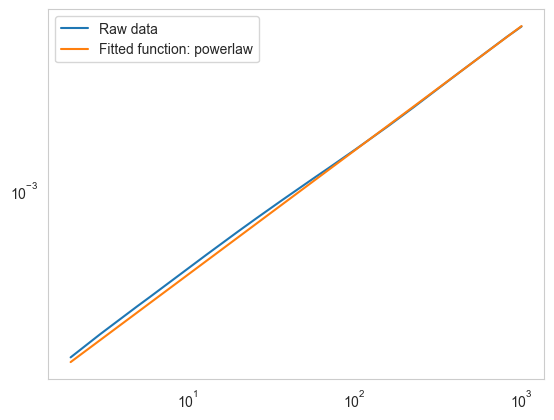

In [62]:
# Retrieve generalized fit object for specific 'STOCK'
tsla_generalized_fit = log_returns_fit_objects[('TSLA', 'generalized', 'log_returns')]
tsla_generalized_fit.powerlaw.plot_fit()

## 4. Return magnitudes

In [63]:
# Return magnitude (volatility)
tsla_volatility = compute_returns(tsla_raw_df)['volatility']
msft_volatility = compute_returns(msft_raw_df)['volatility']
amzn_volatility = compute_returns(amzn_raw_df)['volatility']
nflx_volatility = compute_returns(nflx_raw_df)['volatility']
ebay_volatility = compute_returns(ebay_raw_df)['volatility']
appl_volatility = compute_returns(appl_raw_df)['volatility']

return_magnitudes = {
  'TSLA': tsla_volatility,
  'MSFT': msft_volatility,
  'AMZN': amzn_volatility,
  'NFLX': nflx_volatility,
  'EBAY': ebay_volatility,
  'APPL': appl_volatility
}
# Update the dictionary to only keep the first EVENTS_RANGE items
returns_magnitudes = {stock: data.head(EVENTS_RANGE) for stock, data in return_magnitudes.items()}

### Stationarity Test

In [64]:
# ADF test
for stock, data in return_magnitudes.items():
    augmented_dickey_fuller(data.head(EVENTS_RANGE), stock)

TSLA
ADF: -47.82
p-value: 0.00,
N: 499898, 
critical values: {'1%': -3.4303630813357504, '5%': -2.8615457817964263, '10%': -2.566773077439036}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


MSFT
ADF: -707.15
p-value: 0.00,
N: 499999, 
critical values: {'1%': -3.430363078693302, '5%': -2.861545780628498, '10%': -2.5667730768173898}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


AMZN
ADF: -62.99
p-value: 0.00,
N: 499900, 
critical values: {'1%': -3.4303630812834145, '5%': -2.8615457817732946, '10%': -2.5667730774267237}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.


NFLX
ADF: -47.23
p-value: 0.00,
N: 499898, 
critical values: {'1%': -3.4303630813357504, '5%': -2.8615457817964263, '10%': -2.566773077439036}
We reject the null hypothesis at a significance level of 0.05.
The time series appears to be stationary.



### 4.1. Return magnitude ACF

In [65]:
# Linear ACF
volatility_linear_acf_filename = f"{acf_data_dir}/lo_volatility_linear_acfs.pkl"
volatility_linear_acfs = compute_acfs(filename=volatility_linear_acf_filename, data=return_magnitudes, option='linear')
display(volatility_linear_acfs.keys())

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])

In [66]:
# Nonlinear ACF
volatility_nonlinear_acf_filename = f"{acf_data_dir}/lo_volatility_nonlinear_acfs.pkl"
volatility_nonlinear_acfs = compute_acfs(filename=volatility_nonlinear_acf_filename, data=return_magnitudes, option='nonlinear')
display(volatility_nonlinear_acfs.keys())

/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5218: RuntimeWarning: overflow encountered in scalar multiply
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5218: RuntimeWarning: overflow encountered in scalar multiply
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5218: RuntimeWarning: overflow encountered in scalar multiply
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5218: RuntimeWarning: overflow encountered in scalar multiply
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))
/Users/ana_bugaenko/.conda/envs/py311/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5218: RuntimeWarning: overflow encountered in scalar multipl

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])

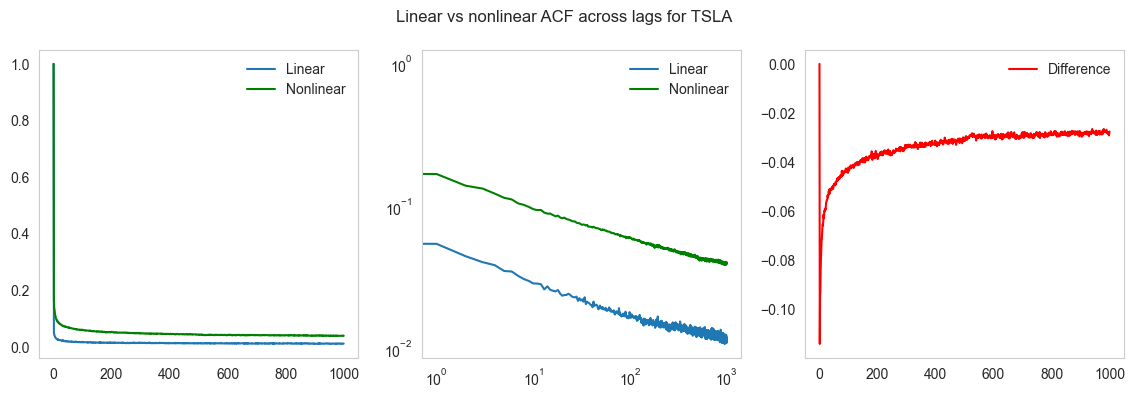

TSLA Max difference: 0.0


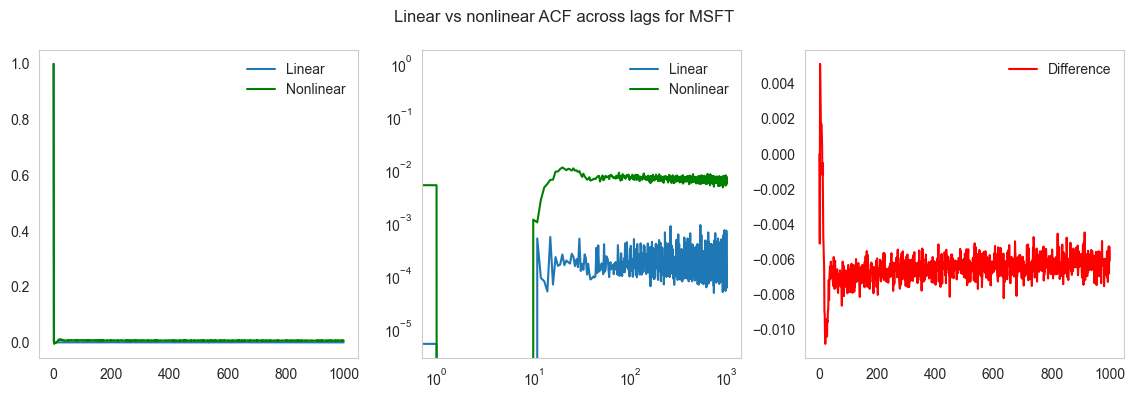

MSFT Max difference: 0.005124866706379401


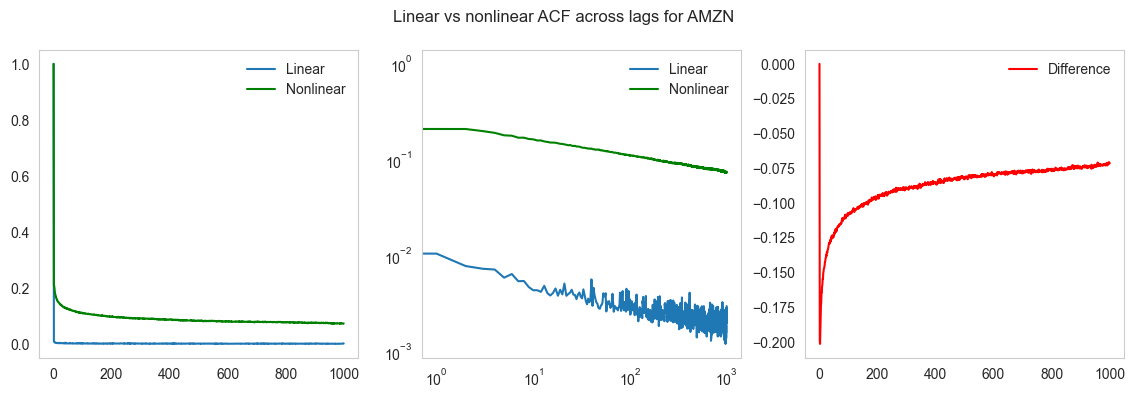

AMZN Max difference: 0.0


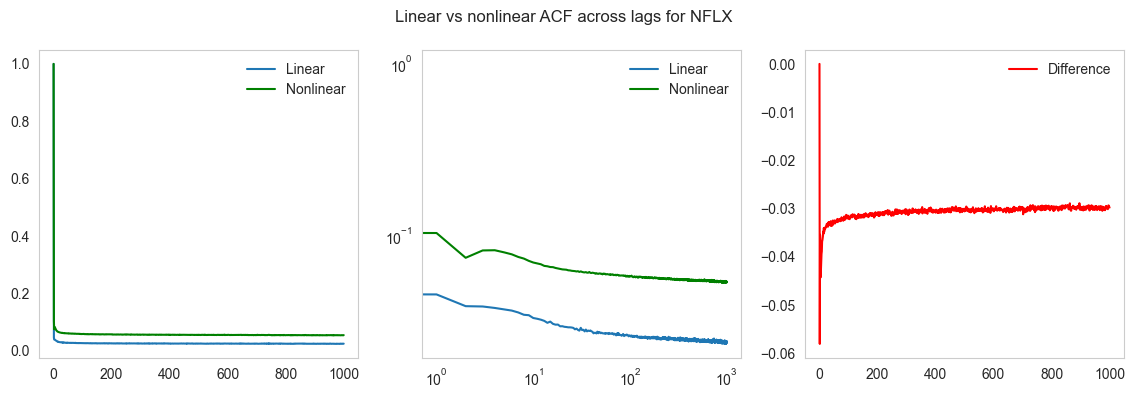

NFLX Max difference: 0.0


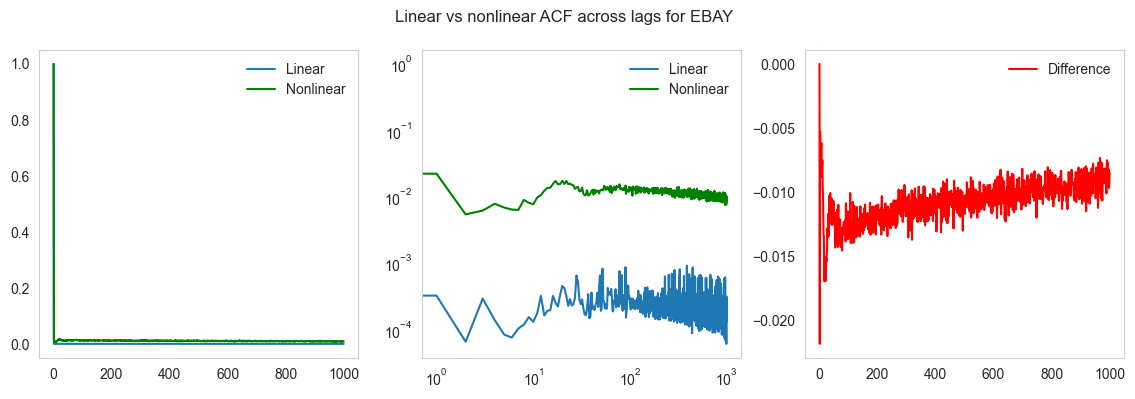

EBAY Max difference: 2.220446049250313e-16


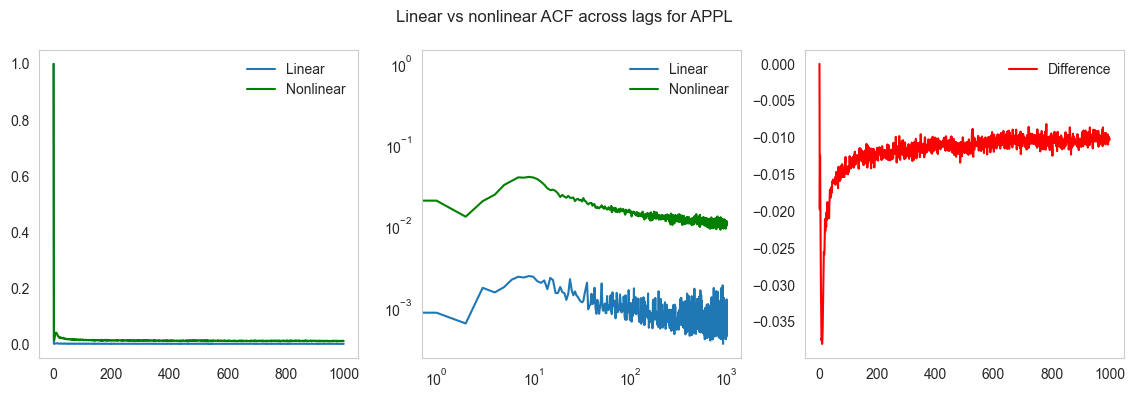

APPL Max difference: 0.0


In [67]:
for stock_name in volatility_linear_acfs.keys():
    plot_acf_difference(stock_name, volatility_linear_acfs, volatility_nonlinear_acfs)

### 4.2. Fit power law to ACF

In [68]:
# Load the pre-computed ACFs
volatility_acf_values = {}

for stock, data in volatility_nonlinear_acfs.items():
    volatility_acf_values[stock] = construct_xy(data, stock)

In [69]:
# Using volatility_nonlinear_acfs
volatility_fit_results_list = []
volatility_fit_objects = {}  # Dictionary to store fit objects

for stock, data in volatility_acf_values.items():
    fit_dict, fit_obj = get_acf_params(stock, data)
    if fit_dict:
        volatility_fit_results_list.append(fit_dict)
        volatility_fit_objects[stock] = fit_obj  # Store the fit object

volatility_acf_fit_results = pd.DataFrame(volatility_fit_results_list)
display(volatility_acf_fit_results.head())

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,gamma,stock
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.1356122...",75,76.0,0.073434,-13566.092162,1.155112,0.986038,-0.180424,TSLA
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0099662...",18,19.0,0.260427,-14575.831779,6.837380,0.287432,-0.066452,MSFT
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.2461666...",6,7.0,0.041206,-14278.204988,0.703552,0.997759,-0.172512,AMZN
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0673220...",54,55.0,0.044351,-15469.402789,0.400419,0.953719,-0.032933,NFLX
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0306399...",207,208.0,0.182620,-11291.613095,6.221277,0.483100,-0.169138,EBAY


In [70]:
avg_alpha = volatility_acf_fit_results['gamma'].mean()
print(f"Average Gamma: {avg_alpha}")

Average Gamma: -0.13182217292691903


In [71]:
volatility_fit_objects.keys()

dict_keys(['TSLA', 'MSFT', 'AMZN', 'NFLX', 'EBAY', 'APPL'])

### 4.3.Volatility Hurst Exponents

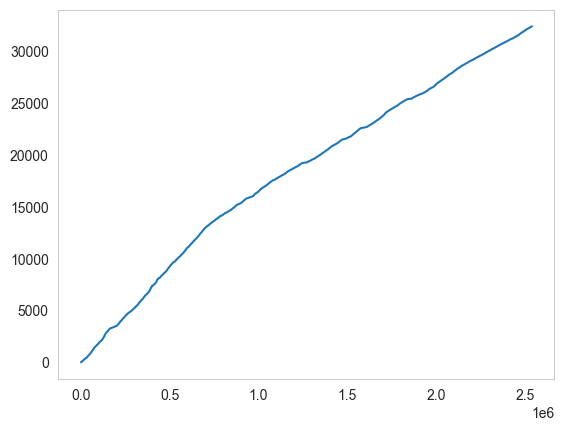

In [72]:
# Return magnitude (volatility)
tsla_volatility = compute_returns(tsla_raw_df)['volatility']
msft_volatility = compute_returns(msft_raw_df)['volatility']
amzn_volatility = compute_returns(amzn_raw_df)['volatility']
nflx_volatility = compute_returns(nflx_raw_df)['volatility']
ebay_volatility = compute_returns(ebay_raw_df)['volatility']
appl_volatility = compute_returns(appl_raw_df)['volatility']

cumsum_return_magnitudes = {
  'TSLA': tsla_volatility.cumsum(),
  'MSFT': msft_volatility.cumsum(),
  'AMZN': amzn_volatility.cumsum(),
  'NFLX': nflx_volatility.cumsum(),
  'EBAY': ebay_volatility.cumsum(),
  'APPL': appl_volatility.cumsum()
}
# Update the dictionary to only keep the first EVENTS_RANGE items
cumsum_return_magnitudes = {stock: data.head(EVENTS_RANGE) for stock, data in cumsum_return_magnitudes.items()}
tsla_cumsum_abs_returns = tsla_volatility.cumsum()
x = list(range(1, len(tsla_cumsum_abs_returns)+1))
plt.plot(x, tsla_cumsum_abs_returns)
plt.grid(False)
plt.show()

#### Standard Hurst

In [73]:
# Standard Hurst
method = 'standard'
volatility_fit_results_list = []
volatility_fit_objects = {}

for stock, data in cumsum_return_magnitudes.items():
    fit_dict, fit = compute_hurst_exponent('volatility', stock, data, method=method, max_lag=LAG)
    if fit_dict:
        volatility_fit_results_list.append(fit_dict)
        volatility_fit_objects[(stock, method, 'volatility')] = fit

volatility_std_hurst_fit_results = pd.DataFrame(volatility_fit_results_list)
display(volatility_std_hurst_fit_results.head(10))

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,standard_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0235871...",1,2.0,0.012748,-4280.899932,2.171529,0.999526,0.841570,TSLA,volatility
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0049576...",1,2.0,0.008499,-11196.573332,0.313212,0.999919,0.509688,MSFT,volatility
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0904417...",1,2.0,0.021246,-2725.335108,3.083205,0.998028,0.710603,AMZN,volatility
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0058402...",1,2.0,0.011331,-6251.832374,2.286924,0.999598,0.853259,NFLX,volatility
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0028321...",1,2.0,0.021246,-9059.313966,2.043846,0.998833,0.607686,EBAY,volatility
5,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0088921...",1,2.0,0.011331,-9304.080694,0.528308,0.999657,0.513759,APPL,volatility


In [74]:
# Average Standard Hurst exponents across stocks
avg_hurst_std = volatility_std_hurst_fit_results['standard_hurst'].mean()
print(f"Average Standard Hurst: {avg_hurst_std}")

Average Standard Hurst: 0.6727607675191227


#### Generalized Hurst

In [75]:
# Generalized Hurst
method = 'generalized'
volatility_fit_results_list = []
volatility_fit_objects = {}

for stock, data in cumsum_return_magnitudes.items():
    fit_dict, fit = compute_hurst_exponent('volatility', stock, data, method=method, max_lag=LAG)
    if fit_dict:
        volatility_fit_results_list.append(fit_dict)
        volatility_fit_objects[(stock, method, 'volatility')] = fit

volatility_gen_hurst_fit_results = pd.DataFrame(volatility_fit_results_list)
display(volatility_gen_hurst_fit_results.head())

/Users/ana_bugaenko/workspace/hurst_exponent/hurst_exponent/hurst_exponent.py:152: UserWarning: Hurst exponent may not be in a valid range (0,1).
  warnings.warn("Hurst exponent may not be in a valid range (0,1).")
/Users/ana_bugaenko/workspace/hurst_exponent/hurst_exponent/hurst_exponent.py:152: UserWarning: Hurst exponent may not be in a valid range (0,1).
  warnings.warn("Hurst exponent may not be in a valid range (0,1).")
/Users/ana_bugaenko/workspace/hurst_exponent/hurst_exponent/hurst_exponent.py:152: UserWarning: Hurst exponent may not be in a valid range (0,1).
  warnings.warn("Hurst exponent may not be in a valid range (0,1).")
/Users/ana_bugaenko/workspace/hurst_exponent/hurst_exponent/hurst_exponent.py:152: UserWarning: Hurst exponent may not be in a valid range (0,1).
  warnings.warn("Hurst exponent may not be in a valid range (0,1).")
/Users/ana_bugaenko/workspace/hurst_exponent/hurst_exponent/hurst_exponent.py:152: UserWarning: Hurst exponent may not be in a valid range (

,function_name,params,xmin_index,xmin,D,bic,mape,adjusted_rsquared,generalized_hurst,stock,random_variate
0,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0185210...",1,2.0,0.001416,-12041.629793,0.003455,1.0,1.000104,TSLA,volatility
1,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0002361...",1,2.0,0.001416,-20468.632996,0.001096,1.0,1.000113,MSFT,volatility
2,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0150362...",1,2.0,0.001416,-10405.815392,0.024274,1.0,1.000786,AMZN,volatility
3,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0077052...",1,2.0,0.001416,-13558.939876,0.003696,1.0,1.000137,NFLX,volatility
4,powerlaw,"{'param_names': ['C', 'alpha'], 'C': 0.0001919...",1,2.0,0.001416,-18185.484277,0.006814,1.0,1.000109,EBAY,volatility


In [76]:
# Generalized Hurst statistic across stocks
min_hurst_gen = volatility_gen_hurst_fit_results['generalized_hurst'].min()
max_hurst_gen = volatility_gen_hurst_fit_results['generalized_hurst'].max()
avg_hurst_gen = volatility_gen_hurst_fit_results['generalized_hurst'].mean()
standard_dev = volatility_gen_hurst_fit_results['generalized_hurst'].std()

print(f"Min Generalized Hurst: {min_hurst_gen}")
print(f"Max Generalized Hurst: {max_hurst_gen}")
print(f"Average Generalized Hurst: {avg_hurst_gen}")
print(f"Standard_dev Generalized Hurst: {standard_dev}")

Min Generalized Hurst: 0.9999542282994829
Max Generalized Hurst: 1.0007858311223425
Average Generalized Hurst: 1.0002005272312604
Standard_dev Generalized Hurst: 0.000294155174530539


In [77]:
print(volatility_fit_objects.keys())

dict_keys([('TSLA', 'generalized', 'volatility'), ('MSFT', 'generalized', 'volatility'), ('AMZN', 'generalized', 'volatility'), ('NFLX', 'generalized', 'volatility'), ('EBAY', 'generalized', 'volatility'), ('APPL', 'generalized', 'volatility')])


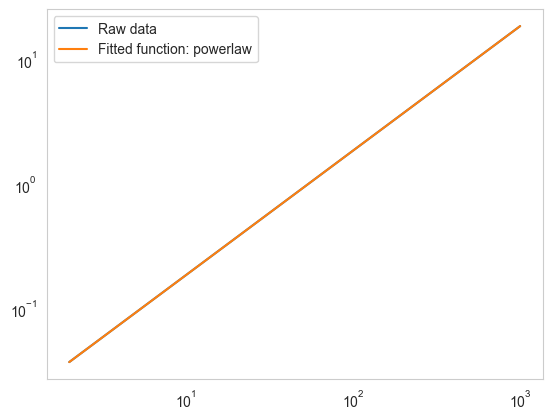

In [78]:
# Retrieve generalized fit object for specific 'STOCK'
tsla_generalized_fit = volatility_fit_objects[('TSLA', 'generalized', 'volatility')]
tsla_generalized_fit.powerlaw.plot_fit()